In [11]:
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Loading Dataset

Considering only more than 3 sec files and
labelling the files as Normal or Abnormal

TODO: Add artifacts (i.e. noises without heartbeat data) and ask the user to try again

In [12]:
dataset = []
for folder in ["./set_a/**","./set_b/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            duration = librosa.get_duration(filename=filename)
            # skip audio smaller than 3 secs
            if duration>=3:
                slice_size = 3
                iterations = int((duration-slice_size)/(slice_size-1))
                iterations += 1
#                 initial_offset = (duration % slice_size)/2
                initial_offset = (duration - ((iterations*(slice_size-1))+1))/2
                if label not in ["Aunlabelledtest", "Bunlabelledtest", "artifact"]:
                    for i in range(iterations):
                        offset = initial_offset + i*(slice_size-1)
                        if (label == "normal"):
                            dataset.append({
                                "filename": filename,
                                "label": "normal",
                                "offset": offset
                            })
                        else:
                            dataset.append({
                                "filename": filename,
                                "label": "abnormal",
                                "offset": offset
                            })
                        
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1281 entries, 1241 to 1126
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  1281 non-null   object 
 1   label     1281 non-null   object 
 2   offset    1281 non-null   float64
dtypes: float64(1), object(2)
memory usage: 40.0+ KB


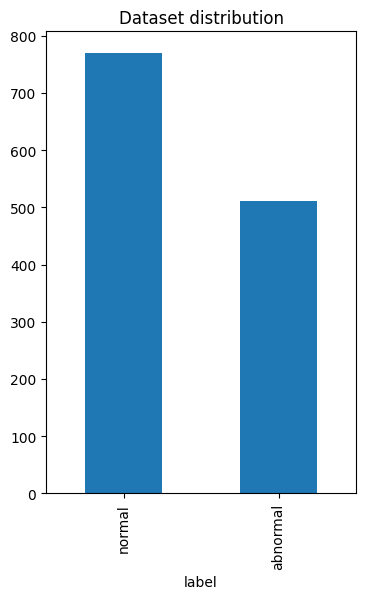

In [13]:
plt.figure(figsize=(4,6))
dataset.label.value_counts().plot(kind='bar', title="Dataset distribution")
plt.show()

## Split dataset in train and test
80-20 Ratio

In [14]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 1024
Test: 257


## Visualising the data and features

./set_b\normal__137_1306764999211_C.wav
./set_b\extrastole__220_1308250132896_B.wav


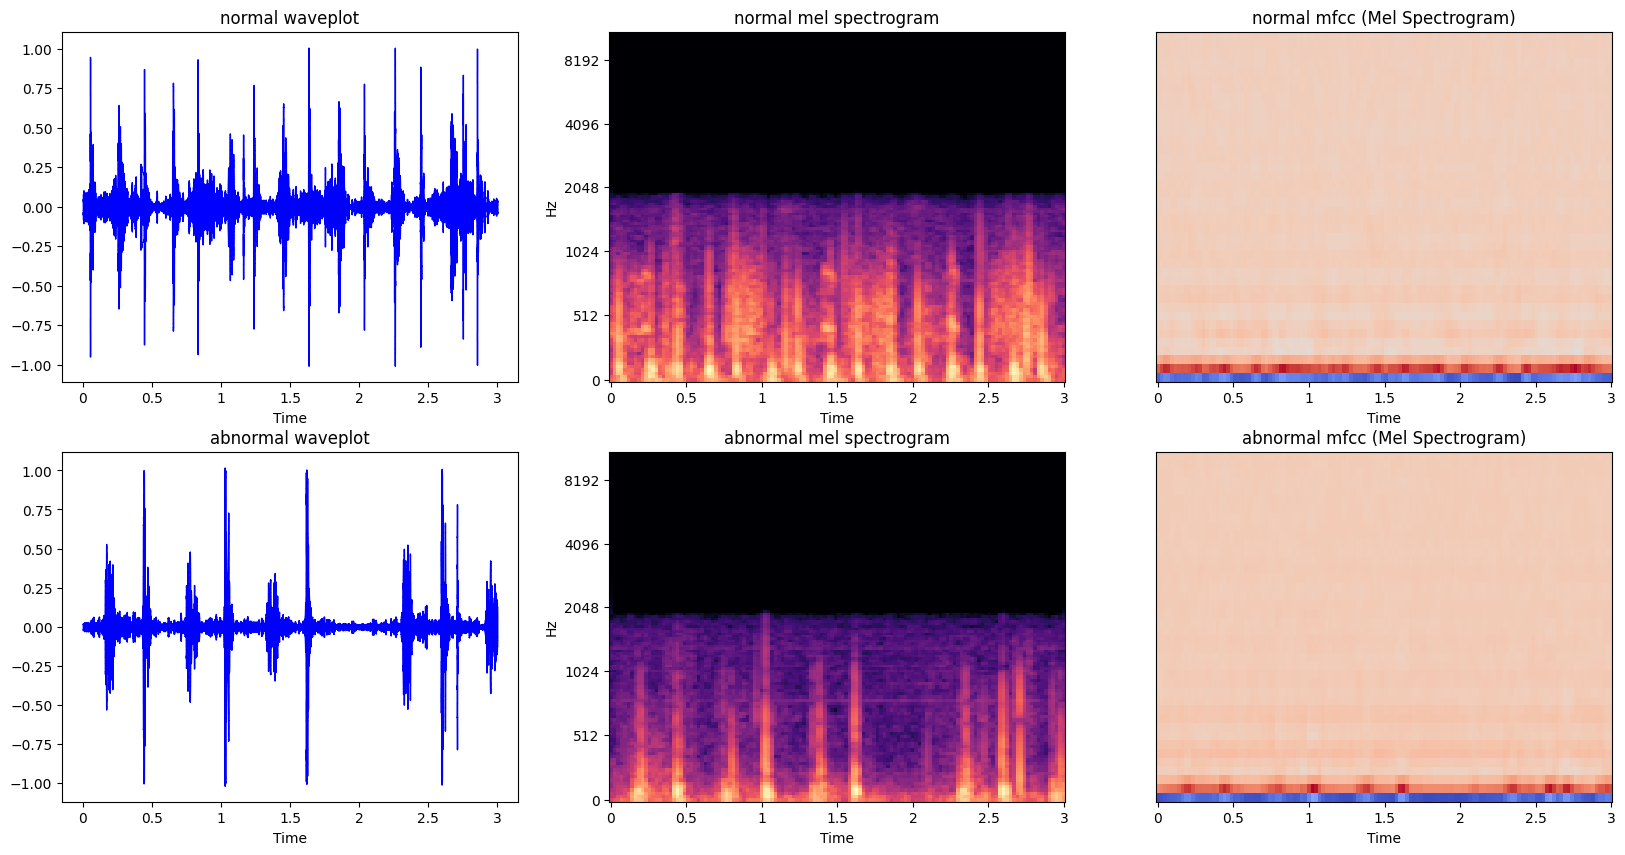

In [17]:
plt.figure(figsize=(20,10))
idx = 0
for label in dataset.label.unique():    
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[33], duration=3)
    print(dataset[dataset.label==label].filename.iloc[33])
    
    # Wave plot
    idx+=1
    plt.subplot(2, 3, idx)
    plt.title("%s waveplot" % label)
    librosa.display.waveshow(y, sr=sr, color="blue")

    # Mel Spectrogram
    idx+=1
    plt.subplot(2, 3, idx)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    plt.title("%s mel spectrogram" % label)

    # MFCC (Mel spectrogram)
    idx+=1
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)
    plt.subplot(2, 3, idx)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title("%s mfcc (Mel Spectrogram)" % label)
plt.show()

## Extracting features

In [21]:
def extract_features(audio_path,offset):
#     y, sr = librosa.load(audio_path, duration=3)
    y, sr = librosa.load(audio_path, offset=offset, duration=3)
#     y = librosa.util.normalize(y)
    
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, 
                                   hop_length=512, 
                                   n_mels=128)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=40)

#     mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfccs

In [22]:
x_train = []
x_test = []

for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx],train.offset.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx],test.offset.iloc[idx]))
    
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

print("X train:", x_train.shape)
print("X test:", x_test.shape)

100%|██████████| 257/257 [00:01<00:00, 166.14it/s]

X train: (1024, 40, 130)
X test: (257, 40, 130)


In [33]:
# Encode Labels
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

## Input Shapes

In [34]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (1024, 40, 130, 1)
Y train: (1024, 2)
X test: (257, 40, 130, 1)
Y test: (257, 2)


## Building Model

In [35]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 39, 129, 16)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 19, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 19, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 18, 63, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 31, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 9, 31, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 30, 64)      │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 15, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 15, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 3, 14, 128)     │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,570 (170.20 KB)

 Trainable params: 43,570 (170.20 KB)

 Non-trainable params: 0 (0.00 B)

## Compiling Model

In [36]:
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

## Fitting Model

In [37]:
%%time
history = model.fit(x_train, y_train,
              batch_size=128,
              epochs=300,
              validation_data=(x_test, y_test),
              class_weight=class_weights_dict,
              shuffle=True)

Epoch 1/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.5281 - loss: 5.4355 - val_accuracy: 0.5914 - val_loss: 1.3935
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.5360 - loss: 3.7008 - val_accuracy: 0.6615 - val_loss: 0.5526
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5502 - loss: 2.2887 - val_accuracy: 0.6732 - val_loss: 0.5095
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5210 - loss: 1.7196 - val_accuracy: 0.5953 - val_loss: 0.5348
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5757 - loss: 1.3838 - val_accuracy: 0.7276 - val_loss: 0.5803
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.6057 - loss: 1.0034 - val_accuracy: 0.6926 - val_loss: 0.6324
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.5869 - loss: 0.9053 - val_accuracy: 0.6537 - val_loss: 0.6523
Epoch 8/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.5772 - loss: 0.8545 - val_accuracy: 0.5370 - val_loss:

## Evaluating model

Text(0.5, 1.0, 'Accuracy Curves')

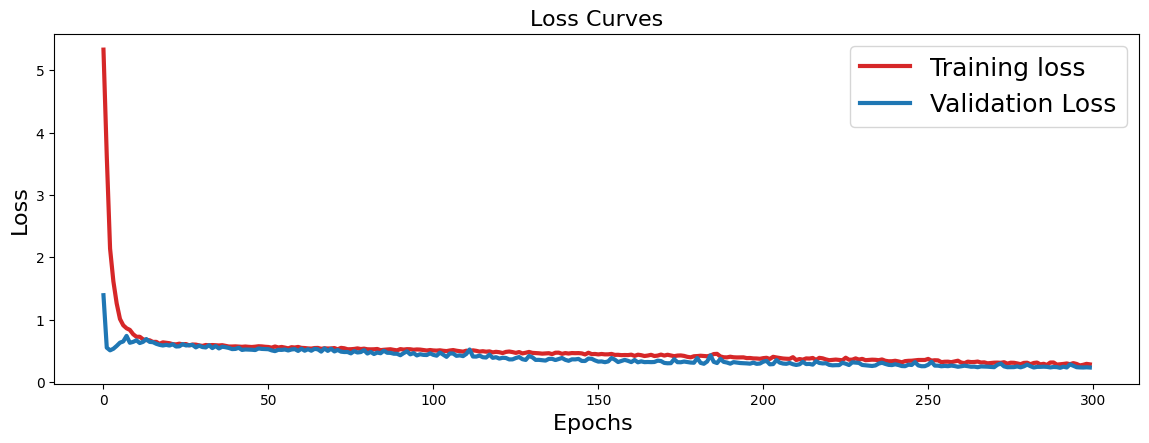

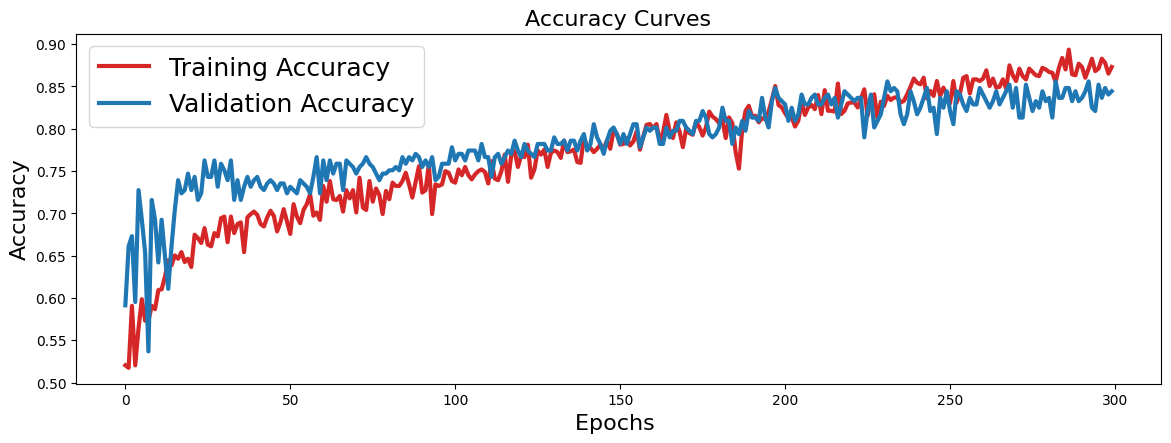

In [38]:
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_loss'],'#1f77b4',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'#d62728',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'#1f77b4',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [39]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8629 - loss: 0.3122 
Test loss: 0.30084848403930664
Test accuracy: 0.844357967376709


In [40]:
predictions = model.predict(x_test, verbose=1)

y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])
    
print(classification_report(y_pred, y_true))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
              precision    recall  f1-score   support

    abnormal       0.76      0.85      0.80        96
      normal       0.91      0.84      0.87       161

    accuracy                           0.84       257
   macro avg       0.83      0.85      0.84       257
weighted avg       0.85      0.84      0.85       257



### Save Model and Weights

In [41]:
model_name = "heartbeat_classifier (normalised).h5"
model.save(model_name)

In [17]:
# 1 sec overlap
# Trained for 3sec for files >3sec

### Classifying an heart beat

In [43]:
# load and evaluate a saved model
from keras.models import load_model
 
# load model
# model = load_model("trained_heartbeat_classifier.h5")
model = load_model("heartbeat_classifier (normalised).h5")

# File to be classified
classify_file = "my_heartbeat.wav"
x_test = []
x_test.append(extract_features(classify_file,0.5))
x_test = np.asarray(x_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
pred = model.predict(x_test,verbose=1)

print(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
[[0.06176681 0.9382332 ]]


In [45]:
pred_probabilities = model.predict(x_test)
pred_class = np.argmax(pred_probabilities, axis=-1)

if pred_class[0]:
    print("Normal heartbeat")
    print("confidence:", pred_probabilities[0][1])
else:
    print("Abnormal heartbeat")
    print("confidence:", pred_probabilities[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Normal heartbeat
confidence: 0.9382332
